# Week 3: CNN Cancer Detection Kaggle Mini-Project


The Histopathologic Cancer Detection Kaggle competition involves a binary image classification problem where the objective is to identify the presence of metastatic cancer in small image patches. These image patches are extracted from larger digital pathology scans of lymph node sections obtained from patients with metastatic breast cancer. The dataset contains over 220,000 image patches, out of which approximately 40% contain metastatic cancer.

The challenge is to develop a deep learning model that can accurately classify these image patches as either malignant or benign based on their visual features. Accurate detection of cancerous regions can assist pathologists in diagnosing and treating cancer, which can potentially improve patient outcomes.

The image patches in the dataset are grayscale and have a size of 96 x 96 pixels. Each image patch is represented as a 2D matrix of pixel values, where the intensity of each pixel ranges from 0 to 255. The dataset is structured as a collection of image files in the PNG format, each labeled as either 0 (benign) or 1 (malignant).

The size of the dataset is quite large, with over 220,000 image patches, which can make training deep learning models challenging due to memory constraints. Additionally, as the dataset is highly imbalanced, with only 40% of the patches containing cancer, there is a need to carefully balance the training data to prevent the model from becoming biased towards the majority class.

# Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import * 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load Training DataFrame

In [2]:
train = pd.read_csv('train_labels.csv', dtype=str)
print(train.shape)

(220025, 2)


In [3]:
train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:
train.id = train.id + '.tif'

In [5]:
train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


# Label Distribution

Look at the distribution of the labels

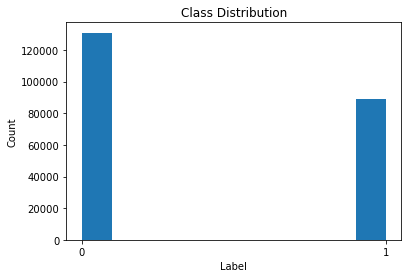

In [26]:
# Plot a histogram of the label distribution
plt.hist(train['label'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [7]:
(train.label.value_counts() / len(train)).to_frame().sort_index().T

,0,1
label,0.594969,0.405031


# Extract Images

In [ ]:
train_path = "C:\\Users\\gjaqu\\Downloads\\histopathologic-cancer-detection.zip\\train"

sample = train.sample(n=16).reset_index()

plt.figure(figsize=(6,6))

for i, row in sample.iterrows():

    img = mpimg.imread(f'C:\\Users\\gjaqu\\Downloads\\histopathologic-cancer-detection.zip\\train{row.id}')    
    label = row.label

    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.text(0, -5, f'Class {label}', color='k')
        
    plt.axis('off')

plt.tight_layout()
plt.show()

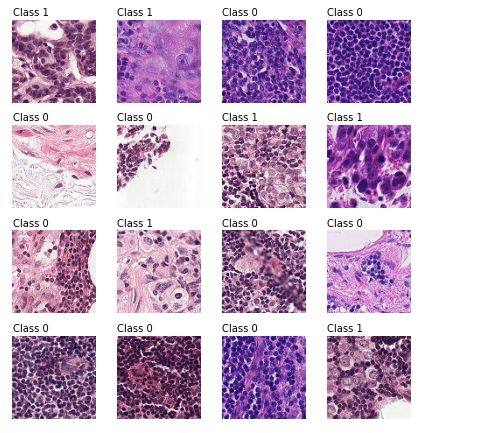

# Training and Validation Sets

In [11]:
train_df, valid_df = train_test_split(train, test_size=0.2, random_state=1, stratify=train.label)

# Data Generators

In [12]:
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

Sets up data generators for training and validation data

In [ ]:
BATCH_SIZE = 64

train_loader = train_datagen.flow_from_dataframe(
    dataframe = valid_df,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (32,32)
)

valid_loader = train_datagen.flow_from_dataframe(
    dataframe = valid_df,
    directory = train_path,
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (32,32)
)

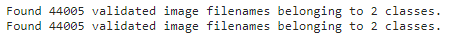

In [ ]:
TR_STEPS = len(train_loader)
VA_STEPS = len(valid_loader)


In [21]:
TR_STEPS = 688
VA_STEPS = 688

# Model Architecture

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Conv2D layer with 16 filters, each with a kernel size of 3x3, ReLU activation function, and same padding to preserve the dimensions of the input image. The input shape of the layer is (32,32,3), meaning that the input images are 32x32 pixels with 3 color channels (RGB).
Another Conv2D layer with the same settings as the previous layer.
A MaxPooling2D layer with a pool size of 2x2 to downsample the feature maps by taking the maximum value in each 2x2 block.
A Dropout layer with a rate of 0.5 to randomly drop 50% of the connections to prevent overfitting.
A BatchNormalization layer to normalize the activations of the previous layer.
Two more pairs of Conv2D, MaxPooling2D, Dropout, and BatchNormalization layers with increasing number of filters (64 and 128).
A Flatten layer to flatten the output of the previous layer into a 1D vector.
Two Dense layers with ReLU activation and Dropout layers to further reduce overfitting.
Another BatchNormalization layer to normalize the activations of the previous layer.
A Dense output layer with 2 units and softmax activation function for classification into two classes.

In [17]:
np.random.seed(1)
tf.random.set_seed(1)

cnn = Sequential([
    Conv2D(16, (3,3), activation = 'relu', padding = 'same', input_shape=(32,32,3)),
    Conv2D(16, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    BatchNormalization(),

    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    BatchNormalization(),
    
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    Conv2D(128, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.5),
    BatchNormalization(),

    Flatten(),
    
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(2, activation='softmax')
])

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 16)        0         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        9

In [18]:
opt = tf.keras.optimizers.Adam(0.001)
cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
%%time 

h1 = cnn.fit(
    x = train_loader, 
    steps_per_epoch = TR_STEPS, 
    epochs = 10,
    validation_data = valid_loader, 
    validation_steps = VA_STEPS, 
    verbose = 1
)

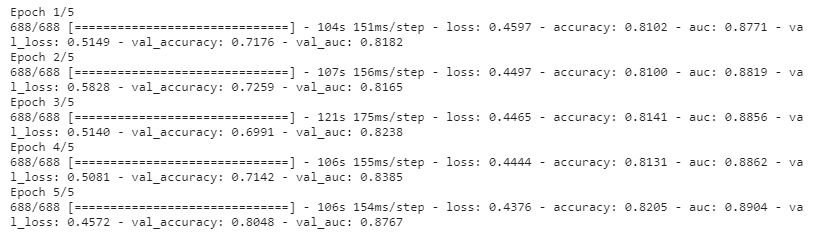

In [ ]:
hist = h1.history

hist will store: 'loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'

In [ ]:
epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,3,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,3,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.subplot(1,3,3)
plt.plot(epoch_range, history['auc'], label='Training')
plt.plot(epoch_range, history['val_auc'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('AUC'); plt.title('AUC')
plt.legend()
plt.tight_layout()
plt.show()

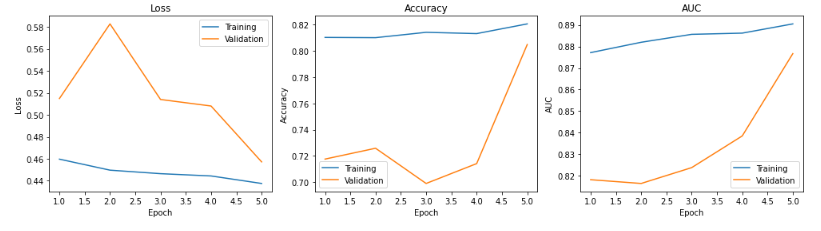

Overall achieved a fairly good accuracy.

# Submission File

# CSV submission for Kaggle

In [ ]:
test_path = "C:/Users/gjaqu/Desktop/test"
print('Test Images:', len(os.listdir(test_path)))

In [ ]:
submission = pd.read_csv('submission.csv')


In [ ]:
submission.label = test_probs[:,1]


In [ ]:
submission.to_csv('submission.csv', header=True, index=False)